# Read MYD35_L2, MYD06_L2 and LID_L2_05km_MLay products and identify the relevant properties

## Read MYD06 file and plot cloud phase

109620
109620
109620
109620
109620
109620


/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


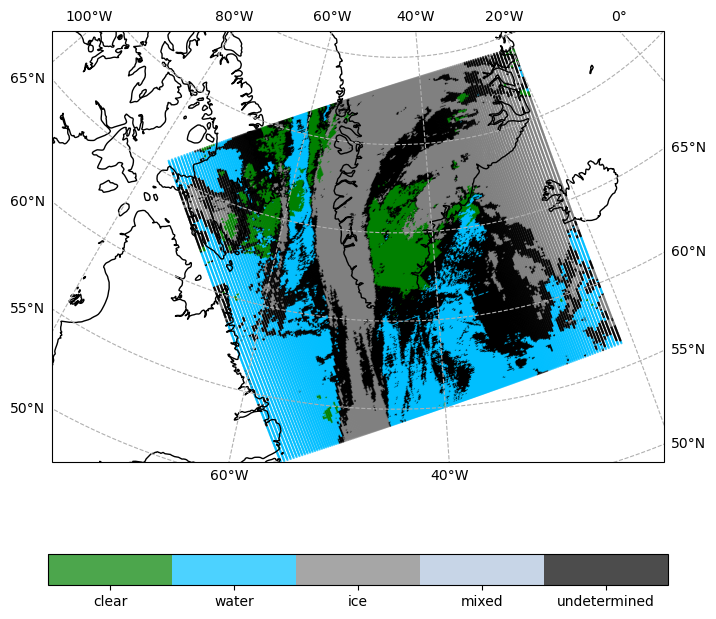

In [121]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

# CALIOP_path = "./test_data/CALIOP/2017/01/CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T14-38-58ZD_Subset.hdf"
MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()

modis_cloud_phase_day = MODIS_reader.select("Cloud_Phase_Infrared_Day").get()
modis_cloud_phase_night = MODIS_reader.select("Cloud_Phase_Infrared_Day").get()
invalid_data_mask_day = modis_cloud_phase_day > 6
invalid_data_mask_night = modis_cloud_phase_night > 6

modis_cloud_phase_day = np.ma.array(modis_cloud_phase_day, mask=invalid_data_mask_day)
modis_cloud_phase_night = np.ma.array(modis_cloud_phase_night, mask=invalid_data_mask_night)

invalid_data_mask = modis_cloud_phase > 6
modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_phase = np.ma.array(modis_cloud_phase, mask=invalid_data_mask)

print(np.size(modis_cloud_phase))


def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=2, cmap=colormap, transform=ccrs.PlateCarree(), alpha=0.7)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))

cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])


## Read MYD06 data and plot cloud fractions

array([[<Axes: title={'center': 'frac'}>]], dtype=object)

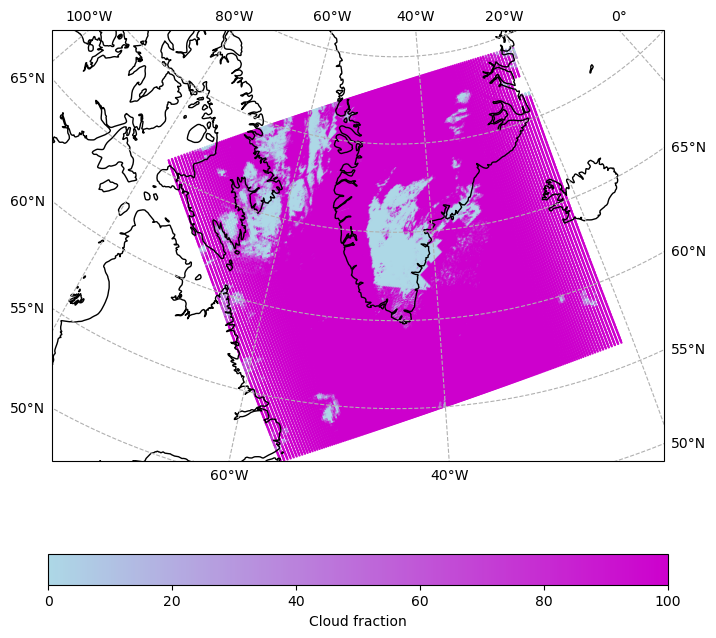

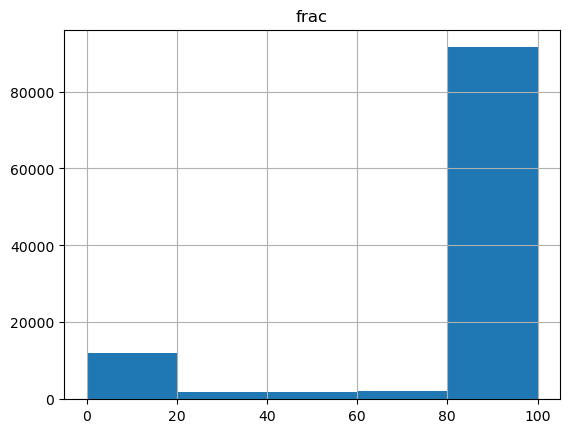

In [133]:
modis_cloud_fraction = MODIS_reader.select("Cloud_Fraction").get()
invalid_data_mask = modis_cloud_fraction > 100

modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_fraction = np.ma.array(modis_cloud_fraction, mask=invalid_data_mask)


def create_skyblue_to_transparent_cmap():
    # Define the colors
    colors = [(173/255, 216/255, 230/255, 1), (205/255, 0/255, 205/255, 1)]

    # Create the colormap
    cmap = LinearSegmentedColormap.from_list("lightblue_to_grey", colors)

    return cmap

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=modis_cloud_fraction, marker='.', s=2, transform=ccrs.PlateCarree(),
                 cmap=create_skyblue_to_transparent_cmap())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", label="Cloud fraction")

import pandas as pd
df = pd.DataFrame(np.array(modis_cloud_fraction).flatten(), columns=["frac"])
df = df[df.frac < 101]
df.hist(bins=5)


## Read MYD06 data and plot cloud mask

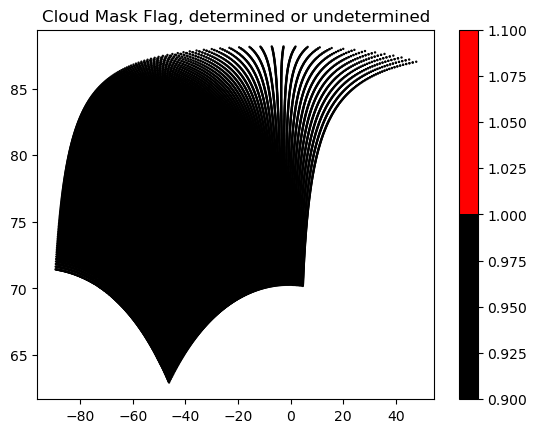

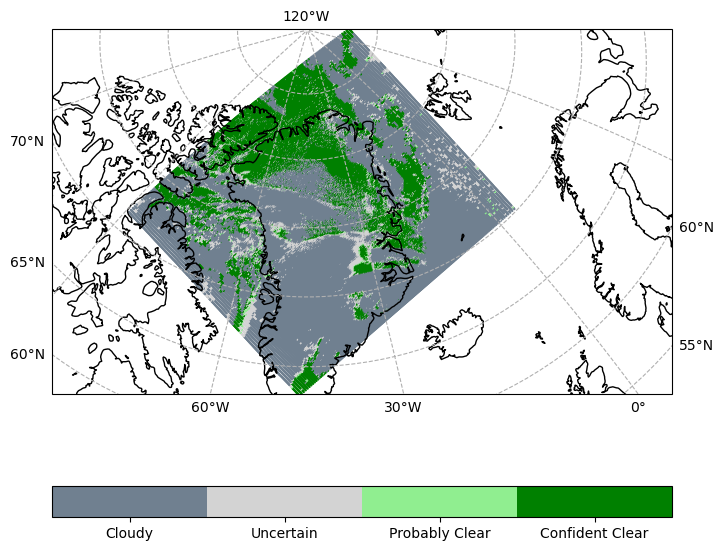

In [166]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_mask_5km = MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0]

# the following section is almost entirely written using ChatGPT

def vectorized_parse_byte_properties(byte_array):
    # Vectorized version of parse_byte_properties function
    properties = {}

    # Bit 0: Cloud Mask Flag
    properties['Cloud Mask Flag'] = np.where((byte_array & 0b1) == 0, 'Not determined', 'Determined')

    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 'Cloudy',
        0b01: 'Uncertain',
        0b10: 'Probably Clear',
        0b11: 'Confident Clear'
    }
    properties['Unobstructed FOV Quality Flag'] = np.vectorize(quality_mapping.get)(quality_flag)

    # Bit 3: Day or Night Path
    properties['Day or Night Path'] = np.where((byte_array >> 2) & 0b1 == 0, 'Night', 'Day')

    # Bit 4: Sunglint Path
    properties['Sunglint Path'] = np.where((byte_array >> 3) & 0b1 == 0, 'Yes', 'No')

    # Bit 5: Snow/Ice Background Path
    properties['Snow/Ice Background Path'] = np.where((byte_array >> 4) & 0b1 == 0, 'Yes', 'No')

    # Bits 7-6: Land or Water Path
    land_water_flag = (byte_array >> 5) & 0b11
    land_water_mapping = {
        0b00: 'Water',
        0b01: 'Coastal',
        0b10: 'Desert',
        0b11: 'Land'
    }
    properties['Land or Water Path'] = np.vectorize(land_water_mapping.get)(land_water_flag)

    return properties

# Example usage with a NumPy array of bytes
byte_array = np.array(modis_cloud_mask_5km, dtype=np.uint8).flatten()
result = vectorized_parse_byte_properties(byte_array)

# Map colors to property values
color_mapping = {
    'Cloudy': 0,
    'Uncertain': 1,
    'Probably Clear': 2,
    'Confident Clear': 4
}

# Extract Unobstructed FOV Quality Flag data
quality_flag_data = result['Unobstructed FOV Quality Flag']
color_matrix = np.vectorize(color_mapping.get)(quality_flag_data)
colormap = ListedColormap(['slategrey', 'lightgrey', 'lightgreen', 'green'])

plt.scatter(modis_long, modis_lat, marker='.', s=2, c=np.where(result["Cloud Mask Flag"] == "Determined", 1, 0), cmap=ListedColormap(["black", "red"]))
plt.colorbar()
plt.gca().set_title("Cloud Mask Flag, determined or undetermined")

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent((np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)), ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
pos = ax.scatter(modis_long, modis_lat, c=color_matrix, marker='.', s=2, transform=ccrs.PlateCarree(), cmap=colormap)
cbar = fig.colorbar(pos, ticks=[0.5, 1.5, 2.5, 3.5], location="bottom")
cbar.set_ticklabels(['Cloudy', 'Uncertain', 'Probably Clear', 'Confident Clear'])

# Use collocation database to load CALIOP and MODIS products